## Main file for training and saving an agent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random

### Import the agent and environment

In [2]:
from Environment import cryptoTrade

from networks.Deep_RL_agents import RNN_agent, convet_to_ragged_tensor

### Define the training loop

In [3]:
def train(env, memory, model, target_model, done):
    learning_rate = 0.7
    discount_factor = 0.9
    
    MIN_REPLAY_SIZE = 1000
    if len(memory) < MIN_REPLAY_SIZE:
        return
    
    batch_size = 64
    mini_batch_indexes = np.random.choice(np.arange(len(memory)), size=batch_size, replace=False)

    current_states = [memory[i][0] for i in mini_batch_indexes]
    current_qs_list = model.predict(convet_to_ragged_tensor(current_states, single=False))
    
    new_current_states = [memory[i][4] for i in mini_batch_indexes]
    future_qs_list = target_model.predict(convet_to_ragged_tensor(new_current_states, single=False))

    X = []
    Y = []
    for index, i in enumerate(mini_batch_indexes):
        (observation, action, actual_action, reward, new_observation, done) = memory[i]
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)
    
    X = convet_to_ragged_tensor(X, single=False)
    model.fit(X, np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

### Do the training

In [4]:
# Create the env and the model
training_data_path = "data/training_2015_2021.df"
env = cryptoTrade(training_data_path, episode_size=720)

model = RNN_agent(env.observation_space, env.action_space)
model.summary()
target_model = RNN_agent(env.observation_space, env.action_space)
target_model.set_weights(model.get_weights())

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 21)                1365      
                                                                 
Total params: 20,565
Trainable params: 20,565
Non-trainable params: 0
_________________________________________________________________


2022-04-06 01:27:22.970446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-06 01:27:22.970601: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# The main loop
epsilon, max_epsilon, min_epsilon = 1, 1, 0.01
decay = 0.01

memory = []

X, y = [], []

steps_to_update_target_model = 0
for episode in range(10):
    total_training_rewards = 0
    
    observation = env.reset()
    
    done = False
    while not done:
        steps_to_update_target_model += 1

        # Implement epsilon greedy learning
        if np.random.rand() <= epsilon:
            action = int(np.random.choice(len(env.action_space)))
        else: 
            action = int(model.predict(convet_to_ragged_tensor(observation, single=True)).argmax())
            
        # Now step the simulation
        actual_action, new_observation, reward, done = env.step(action)
        memory.append([observation, action, actual_action, reward, new_observation, done])
        
        # Update the neural network
        if (steps_to_update_target_model % 4 == 0) or done:
            train(env, memory, model, target_model, done)
            
        observation = new_observation
        total_training_rewards += reward
        
        if done:
            #print('Total epoch rewards (profit): {:.2e} after {} steps'.format(total_training_rewards, episode))
            print('Total epoch rewards (profit): {:.2e} after {} steps'.format(reward, episode))

            if steps_to_update_target_model >= 100:
#                 print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
        
    # Update epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

# target_model.save('')

Total epoch rewards (profit): 1.05e+04 after 0 steps


2022-04-06 01:27:24.281871: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-06 01:27:24.282556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-06 01:27:24.323812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-06 01:27:24.598440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-06 01:27:24.634609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-06 01:27:25.239116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-06 01:27:25.361548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

Total epoch rewards (profit): -1.32e+04 after 1 steps
Total epoch rewards (profit): -4.80e+03 after 2 steps


KeyboardInterrupt: 

# Test the model

In [6]:
# Create the env and the model
testing_data_path = "data/testing_2022.df"
testing_env = cryptoTrade(testing_data_path, episode_size=720)

observation = testing_env.reset()
done = False
val_memory = []

while not done:
    action = int(model.predict(convet_to_ragged_tensor(observation, single=True)).argmax())
    actual_action, new_observation, reward, done = testing_env.step(action)
    
    info = {"observation":observation.copy(), "action":action, "actual_action":actual_action, 
            "reward":reward, "new_observation":new_observation.copy(), "done":done}
    val_memory.append(info)
    
    observation = new_observation

In [7]:
# Plot the results
observations = [x["observation"] for x in val_memory]
actions = [x["action"] for x in val_memory]
actual_actions = [x["actual_action"] for x in val_memory]
rewards = [x["reward"] for x in val_memory]
new_observations = [x["new_observation"] for x in val_memory]

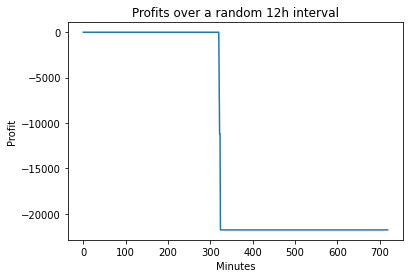

In [9]:
plt.figure()
plt.plot(rewards)
plt.title("Profits over a random 12h interval")
plt.xlabel("Minutes")
plt.ylabel("Profit")
plt.show()

In [ ]:
# EXPAND THE DATA WE ARE USING
# TEST ON TESTING DATASET
# PLOT THE RESULTS
# CREATE BUY SELL ANIMATION
# DO A DNN AFTER EVAL IS CREATED

In [ ]:
import itertools
for i, j in itertools.product(range(10), range(10, 21)):
    print(i, j)

In [ ]:
import time
time.time()

In [ ]:
time.time()